# Representation of Semantic Segmentation UNet Model
# applied to kaggle data-science-bowl-2018 dataset

## 0. Required Imports

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

## 1. Data Preprocessing

In [2]:
class DataGen(keras.utils.Sequence):
    """
    Creates Data Generator which takes data from dataset and transforms it to required form
    """
    def __init__(self, ids, path, batch_size=8, image_size=128):  # Specifies images to the same size
        self.ids = ids  # IDs of images
        self.path = path  # Images' placement
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        # Path of loading images and masks using corresponding id_names
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        # Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        # Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))  # 128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        # Normalizing Image and Mask
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        files_batch = self.ids[index * self.batch_size: (index + 1) * self.batch_size]

        image = []
        mask = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

## 2. Hyperparameters

In [3]:
# General parameters
image_size = 128
train_path = "dataset/stage1_train/"
epochs = 5
batch_size = 8

# Training IDs
train_ids = next(os.walk(train_path))[1]

# Validation data size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

## 3. Data Preview

In [4]:
# Shows how images and masks (which are got by the Data Generator) look in general
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


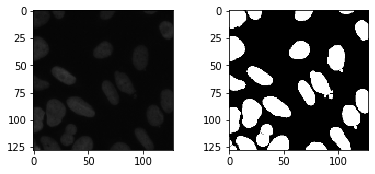

In [5]:
# Gets random image and its mask
r = random.randint(0, len(x) - 1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## 4. Differnent Convolutional Blocks

In [6]:
# We require convolutional blocks of different constitution to build a model with UNet architecture
# For this we will combine convolution (c) and pool (p) operations
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p


def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1): # UNet has skip-connections
    us = keras.layers.UpSampling2D((2, 2))(x) # upsampling (us)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat) # concat is input here
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## 5. UNet Model

In [7]:
def UNet():
    """
    Represents a model with UNet-type architecture

    """
    f = [16, 32, 64, 128, 256]  # feature maps
    inputs = keras.layers.Input((image_size, image_size, 3))

    # Downsampling part
    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 -> 64
    c2, p2 = down_block(p1, f[1])  # 64 -> 32
    c3, p3 = down_block(p2, f[2])  # 32 -> 16
    c4, p4 = down_block(p3, f[3])  # 16-> 8

    # Middle (Bottleneck) part
    bn = bottleneck(p4, f[4])

    # Upsampling part
    u1 = up_block(bn, c4, f[3])  # 8 -> 16
    u2 = up_block(u1, c3, f[2])  # 16 -> 32
    u3 = up_block(u2, c2, f[1])  # 32 -> 64
    u4 = up_block(u3, c1, f[0])  # 64 -> 128

    # Final layer
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)

    # Model overall
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
# Dice coefficient and loss funcion definition
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [9]:
# Model compiling and summing up 
model = UNet()
# !!! Creating a model compilation with Dice loss function has some issues in our case
# !!! dice_loss = dice_loss(y_true, y_pred)
# !!! model.compile(optimizer="sgd", loss="dice_loss", metrics=["dice_coef"]) # not working
# !!! So here used some common compile parameters
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## 6. Training the Model

In [10]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids) // batch_size
valid_steps = len(valid_ids) // batch_size

model.fit(train_gen,
          validation_data=valid_gen,
          steps_per_epoch=train_steps,
          validation_steps=valid_steps,
          epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 1 steps
Epoch 1/5
82/82 [==============================] - 1090s 13s/step - loss: 0.4187 - accuracy: 0.8426 - val_loss: 0.3329 - val_accuracy: 0.8186
Epoch 2/5
82/82 [==============================] - 369s 5s/step - loss: 0.2654 - accuracy: 0.8518 - val_loss: 0.0881 - val_accuracy: 0.9496
Epoch 3/5
82/82 [==============================] - 347s 4s/step - loss: 0.1711 - accuracy: 0.9162 - val_loss: 0.1487 - val_accuracy: 0.9325
Epoch 4/5
82/82 [==============================] - 347s 4s/step - loss: 0.1402 - accuracy: 0.9343 - val_loss: 0.0611 - val_accuracy: 0.9606
Epoch 5/5
82/82 [==============================] - 344s 4s/step - loss: 0.1309 - accuracy: 0.9375 - val_loss: 0.0518 - val_accuracy: 0.9656


## 7. Testing the Model

In [11]:
# Save the weights
model.save_weights("UNetWeigths.h5")

# Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

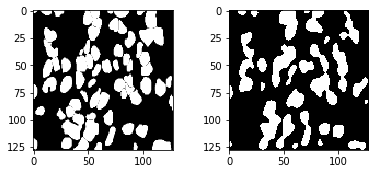

In [12]:
# Matchings [0]
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

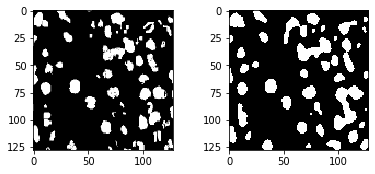

In [13]:
# Matchings [1]
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")